In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import glob
import tensorflow as tf

In [2]:
from zipfile import ZipFile

In [3]:
data_path = 'archive.zip'

In [4]:
# with ZipFile(data_path, 'r') as zip:
#     zip.extractall()
#     print('Data Extracted')

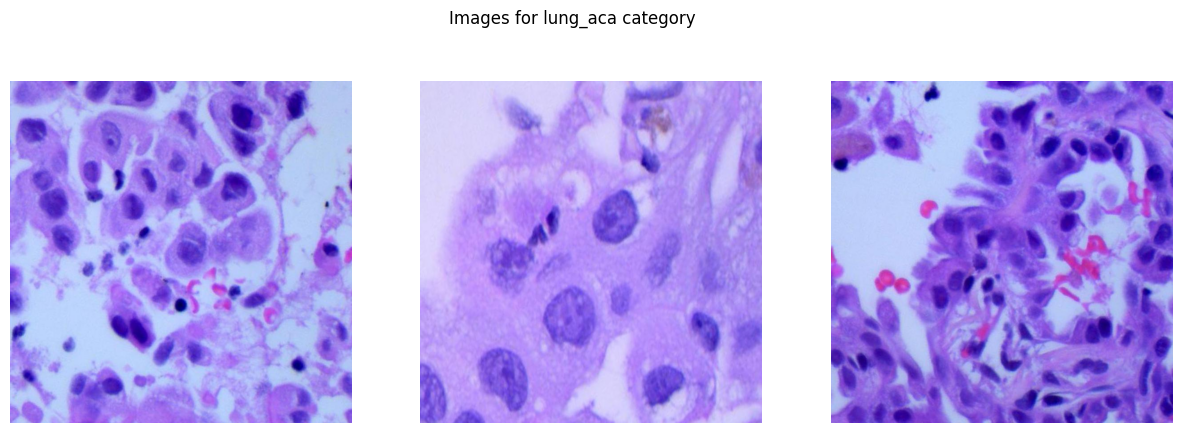

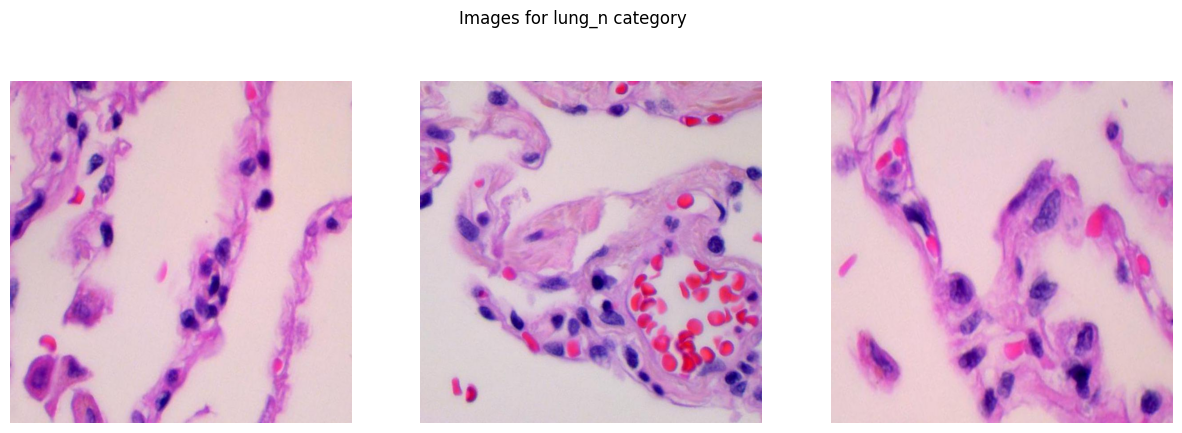

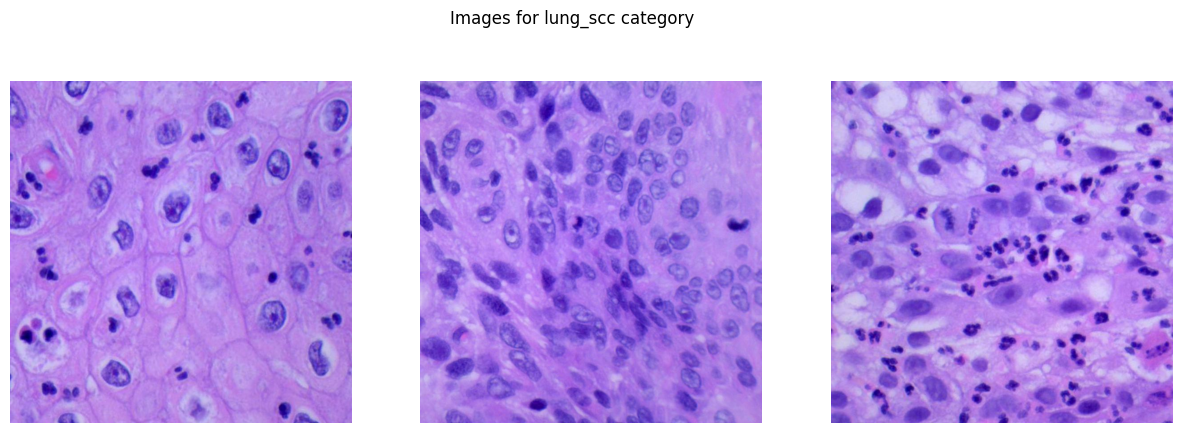

In [5]:
path = 'lung_colon_image_set/lung_image_sets'
classes = ['lung_aca', 'lung_n', 'lung_scc']

for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    fig.suptitle(f'Images for {cat} category')

    for i in range(3):
        k = np.random.randint(0, len(images))
        # img = (cv2.imread(f'{image_dir}/{images[k]}', cv2.COLOR_BGR2RGB))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [6]:
IMG_SIZE = 256
EPOCHS = 10
BATCH_SIZE = 64
SEED = 42

# X = []
# Y = []

# for i, cat in enumerate(classes):
#     images = glob.glob(f'{path}/{cat}/*.jpeg')

#     for image in images:
#         img = cv2.imread(image)
#         X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
#         Y.append(i)

train_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    validation_split=0.2,
    subset='training',
    seed=SEED,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    shuffle=True
)

print("Classes:", train_ds.class_names)
num_classes = len(train_ds.class_names)

Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Found 15000 files belonging to 3 classes.
Using 3000 files for validation.
Classes: ['lung_aca', 'lung_n', 'lung_scc']


In [7]:
def normalize(x,y):
    x = tf.cast(x, tf.float32)/255.0
    return x,y

train_ds = (train_ds.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
                     .prefetch(tf.data.AUTOTUNE))
val_ds   = (val_ds.map(normalize,   num_parallel_calls=tf.data.AUTOTUNE)
                     .prefetch(tf.data.AUTOTUNE))

In [8]:
# for i in range(5):
#     print(f"Image {i} shape: {X[i].shape}, dtype: {X[i].dtype}")

In [9]:
# print(X[0].shape)

In [10]:
# X = np.asarray(X)

In [11]:
# X[0].shape

In [12]:
# print(Y)

In [13]:
# one_hot_encoded_Y = pd.get_dummies(Y).astype(int).values

In [14]:
# print(one_hot_encoded_Y)

In [15]:
# from sklearn.model_selection import train_test_split
# X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y, test_size=0.2, random_state=2022)

In [16]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [17]:
model = keras.models.Sequential([
    # layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    
    layers.Conv2D(
        filters=32,
        kernel_size = (5,5),
        activation = 'relu',
        input_shape = (IMG_SIZE, IMG_SIZE, 3), #IMG_SIZE = 256
        padding = 'same'
    ),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(
        filters=64,
        kernel_size= (3,3),
        activation = 'relu',
        padding='same'
    ),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(
        filters = 128,
        kernel_size = (3,3),
        activation = 'relu',
        padding = 'same'
    ),
    layers.MaxPooling2D(2,2),

    # layers.Flatten()
    layers.GlobalAveragePooling2D(), 
    layers.Dense(256, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

model.summary()

C:\Users\Ankit Regmi\anaconda3\envs\tf_notebook\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 162,627 (635.26 KB)

 Trainable params: 161,859 (632.26 KB)

 Non-trainable params: 768 (3.00 KB)

In [18]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

tensorboard_callback = TensorBoard(log_dir='logs', histogram_freq=1)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto 90% so, stopping further training')
            self.mode.stop_training = True

es = EarlyStopping(
    monitor = 'val_loss', 
    restore_best_weights=True
)

lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    patience=2, 
    factor=0.5, 
    verbose=1
)

mc = ModelCheckpoint(
    "best.keras",
    save_best_only=True,
    monitor='val_loss'
)

In [20]:
history = model.fit(train_ds, 
                   validation_data = val_ds,
                   epochs = EPOCHS,
                   verbose=1,
                   callbacks=[es, lr,mc, myCallback()]
                              )

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.8599 - loss: 0.3306 - val_accuracy: 0.4133 - val_loss: 1.3026 - learning_rate: 0.0010
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 278s 1s/step - accuracy: 0.9043 - loss: 0.2343 - val_accuracy: 0.6513 - val_loss: 0.6693 - learning_rate: 0.0010
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 279s 1s/step - accuracy: 0.9170 - loss: 0.2091 - val_accuracy: 0.8293 - val_loss: 0.4532 - learning_rate: 0.0010
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.9197 - loss: 0.2002 - val_accuracy: 0.7347 - val_loss: 1.1529 - learning_rate: 0.0010


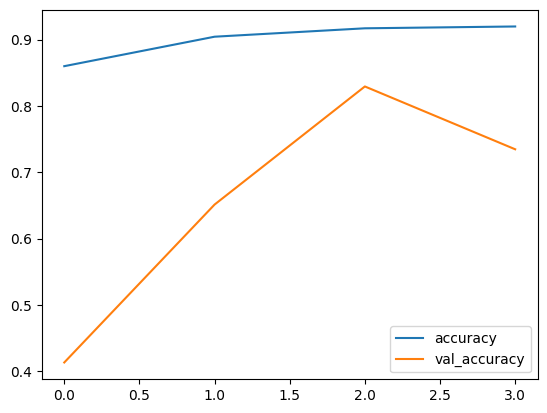

In [21]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()